# Statistical forecast
## Imports

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import statsmodels.api as stm
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset

## Load data
Load the data from previous files.

In [114]:
predicted_percipitation: pd.DataFrame = pd.read_hdf("prediction_data.hdf5", "prediction_data_24h")
predicted_percipitation

,,det_run,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,mean_pred,median_pred,min_pred,max_pred,pred_std,pred_skew,pred_kurt,mode_pred,mode2_pred,mean_det_pred
date,loc_nr,,,,,,,,,,,,,,,,,,,,,
2016-04-01,260,0,0,0,0,0,0,0,0,0,0,...,0.16,0.0,0,3,0.509502,4.129082,19.937964,0.000000,0.0,0.08
2016-04-02,260,1,1,5,2,3,3,1,1,2,1,...,2.66,2.0,0,16,3.360090,2.668093,7.322484,2.000000,2.0,1.83
2016-04-03,260,34,20,8,22,19,26,19,28,12,25,...,25.90,22.0,8,75,14.570378,1.523376,2.709633,19.333333,19.0,29.95
2016-04-04,260,17,44,54,29,29,44,54,9,61,22,...,33.40,29.0,7,88,16.099182,1.028039,1.597512,36.200000,29.0,25.20
2016-04-05,260,30,18,8,24,58,36,41,30,43,25,...,31.30,31.5,8,62,15.708116,0.159005,-1.070315,8.000000,8.0,30.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,240,0,0,0,0,0,0,0,0,0,0,...,0.00,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.00
2021-04-27,240,0,0,0,0,2,0,0,1,0,1,...,0.36,0.0,0,3,0.692820,2.062579,4.056756,0.000000,0.0,0.18
2021-04-28,240,41,27,10,38,29,5,31,14,32,20,...,22.82,21.0,3,59,14.342302,0.655763,-0.160606,14.000000,14.0,31.91


In [115]:
def rmse(true, predicted):
    return np.sqrt(((true - predicted) ** 2).mean())

def mae(true, predicted):
    return np.abs(true - predicted).mean()

def smae(true, predicted):
    return (np.abs(true - predicted)/((np.abs(predicted) + np.abs(true))/2)).mean()

def get_error_statistics(true, predicted):
    print(f"RMSE: {rmse(true, predicted)}, MAE: {mae(true, predicted)}, SMAE: {smae(true, predicted)}")

### Calculate daily rainfall
Here we calculate the daily rainfall.

In [116]:
true_weather = pd.read_hdf("weather_data.hdf5", "measured_data")
rainfall: pd.DataFrame = true_weather["RH-fix"]
daily_rainfall = rainfall.groupby([pd.Grouper(freq="D", level=0), rainfall.index.get_level_values(1)]).sum()
daily_rainfall.index.rename(["date", "loc_nr"], inplace=True)
daily_rainfall = daily_rainfall * 10
daily_rainfall

date        loc_nr
1951-01-01  240         0.0
            260        23.0
            310         0.0
1951-01-02  240         0.0
            260        25.0
                      ...  
2022-06-05  260       259.0
            310       209.0
2022-06-06  240        44.0
            260       114.0
            310       109.0
Name: RH-fix, Length: 78267, dtype: float64

### Calculate if has rained
Here we calculate if it has rained.

In [117]:
is_raining: pd.Series = true_weather["R"]
daily_is_raining = is_raining.groupby([pd.Grouper(freq="D", level=0), rainfall.index.get_level_values(1)]).max()
daily_is_raining

date        STN
1951-01-01  240    1.0
            260    1.0
            310    1.0
1951-01-02  240    1.0
            260    1.0
                  ... 
2022-06-05  260    1.0
            310    1.0
2022-06-06  240    1.0
            260    1.0
            310    1.0
Name: R, Length: 78267, dtype: float64

Finally we join this data with the predicted data.

In [118]:
combined_data = predicted_percipitation.join([daily_rainfall, daily_is_raining])
# combined_data = combined_data.loc[combined_data.index.get_level_values(1) == 260] # Only run on one station
combined_data

,,det_run,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,min_pred,max_pred,pred_std,pred_skew,pred_kurt,mode_pred,mode2_pred,mean_det_pred,RH-fix,R
date,loc_nr,,,,,,,,,,,,,,,,,,,,,
2016-04-01,260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.509502,4.129082,19.937964,0.000000,0.0,0.08,0.0,0.0
2016-04-02,260,1.0,1.0,5.0,2.0,3.0,3.0,1.0,1.0,2.0,1.0,...,0.0,16.0,3.360090,2.668093,7.322484,2.000000,2.0,1.83,0.0,1.0
2016-04-03,260,34.0,20.0,8.0,22.0,19.0,26.0,19.0,28.0,12.0,25.0,...,8.0,75.0,14.570378,1.523376,2.709633,19.333333,19.0,29.95,97.0,1.0
2016-04-04,260,17.0,44.0,54.0,29.0,29.0,44.0,54.0,9.0,61.0,22.0,...,7.0,88.0,16.099182,1.028039,1.597512,36.200000,29.0,25.20,63.0,1.0
2016-04-05,260,30.0,18.0,8.0,24.0,58.0,36.0,41.0,30.0,43.0,25.0,...,8.0,62.0,15.708116,0.159005,-1.070315,8.000000,8.0,30.65,14.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0
2021-04-27,240,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,...,0.0,3.0,0.692820,2.062579,4.056756,0.000000,0.0,0.18,0.0,0.0
2021-04-28,240,41.0,27.0,10.0,38.0,29.0,5.0,31.0,14.0,32.0,20.0,...,3.0,59.0,14.342302,0.655763,-0.160606,14.000000,14.0,31.91,0.0,1.0


We also add a binary variable if it is a certain location.

In [119]:
for location in combined_data.index.get_level_values(1).unique():
    combined_data.loc[:, f"is-{location}"] = (combined_data.index.get_level_values(1) == location).astype(int)

combined_data

,,det_run,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,pred_skew,pred_kurt,mode_pred,mode2_pred,mean_det_pred,RH-fix,R,is-260,is-310,is-240
date,loc_nr,,,,,,,,,,,,,,,,,,,,,
2016-04-01,260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.129082,19.937964,0.000000,0.0,0.08,0.0,0.0,1,0,0
2016-04-02,260,1.0,1.0,5.0,2.0,3.0,3.0,1.0,1.0,2.0,1.0,...,2.668093,7.322484,2.000000,2.0,1.83,0.0,1.0,1,0,0
2016-04-03,260,34.0,20.0,8.0,22.0,19.0,26.0,19.0,28.0,12.0,25.0,...,1.523376,2.709633,19.333333,19.0,29.95,97.0,1.0,1,0,0
2016-04-04,260,17.0,44.0,54.0,29.0,29.0,44.0,54.0,9.0,61.0,22.0,...,1.028039,1.597512,36.200000,29.0,25.20,63.0,1.0,1,0,0
2016-04-05,260,30.0,18.0,8.0,24.0,58.0,36.0,41.0,30.0,43.0,25.0,...,0.159005,-1.070315,8.000000,8.0,30.65,14.0,1.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,0,0,1
2021-04-27,240,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,...,2.062579,4.056756,0.000000,0.0,0.18,0.0,0.0,0,0,1
2021-04-28,240,41.0,27.0,10.0,38.0,29.0,5.0,31.0,14.0,32.0,20.0,...,0.655763,-0.160606,14.000000,14.0,31.91,0.0,1.0,0,0,1


In [120]:
combined_data.columns # These are all the columns we have

Index(['det_run', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10',
       'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20',
       'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29', 'E30',
       'E31', 'E32', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E40',
       'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48', 'E49', 'E50',
       'E51', 'mean_pred', 'median_pred', 'min_pred', 'max_pred', 'pred_std',
       'pred_skew', 'pred_kurt', 'mode_pred', 'mode2_pred', 'mean_det_pred',
       'RH-fix', 'R', 'is-260', 'is-310', 'is-240'],
      dtype='object')

## Basic model(s)
First we test how some basic models perform.
### OLS on deterministic forecast

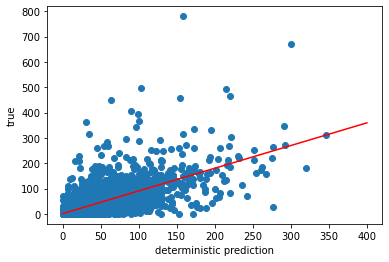

RMSE: 29.220307490727176, MAE: 12.005925541903304, SMAE: 1.2995106447287346


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.544     
Dependent Variable: RH-fix           AIC:                39959.5452
Date:               2022-06-20 12:02 BIC:                39972.1876
No. Observations:   4110             Log-Likelihood:     -19978.   
Df Model:           1                F-statistic:        4896.     
Df Residuals:       4108             Prob (F-statistic): 0.00      
R-squared:          0.544            Scale:              976.67    
---------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
---------------------------------------------------------------------
const         1.0382     0.5664    1.8328   0.0669   -0.0724   2.1487
det_run       0.8958     0.0128   69.9742   0.0000    0.8707   0.9209
-------------------------------------------------------------------
Omnibus:            3875.654      Durbin-Watson:         1.970     
Prob(Omnibus):      0.000         Jarque-Bera (JB):      331017.692
Skew:               4.262         Prob(JB):              0.000     
Kurtosis:           46.131        Condition No.:         51        
===================================================================

"""

In [121]:
combined_data_model = combined_data[combined_data.index.get_level_values(0) < datetime.datetime(2020, 1, 1)]
combined_data_test = combined_data[combined_data.index.get_level_values(0) >= datetime.datetime(2020, 1, 1)]

ols_det = stm.OLS(combined_data_model["RH-fix"], stm.add_constant(combined_data_model[["det_run"]])).fit()
plt.scatter(combined_data["det_run"], combined_data[["RH-fix"]])
plt.xlabel("deterministic prediction")
plt.ylabel("true")
x = np.linspace(0, 400)
plt.plot(x, ols_det.predict(stm.add_constant(x)), color="red")
plt.show()

ols_det_predict = ols_det.predict(stm.add_constant(combined_data_test["det_run"]))
get_error_statistics(combined_data_test["RH-fix"], ols_det_predict)

ols_det.summary2()

### OLS on mean

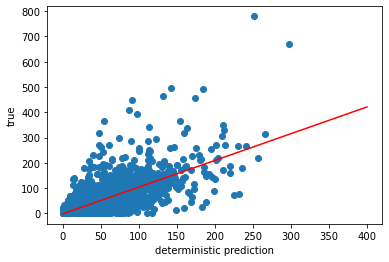

RMSE: 27.260527206569204, MAE: 12.120870039677289, SMAE: 1.3118150088542002


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.592     
Dependent Variable: RH-fix           AIC:                39500.8007
Date:               2022-06-20 12:02 BIC:                39513.4430
No. Observations:   4110             Log-Likelihood:     -19748.   
Df Model:           1                F-statistic:        5960.     
Df Residuals:       4108             Prob (F-statistic): 0.00      
R-squared:          0.592            Scale:              873.53    
---------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const       -2.0685     0.5510   -3.7542   0.0002   -3.1487   -0.9883
mean_pred    1.0577     0.0137   77.1988   0.0000    1.0308    1.0846
-------------------------------------------------------------------
Omnibus:            3592.389      Durbin-Watson:         1.972     
Prob(Omnibus):      0.000         Jarque-Bera (JB):      253988.027
Skew:               3.813         Prob(JB):              0.000     
Kurtosis:           40.749        Condition No.:         48        
===================================================================

"""

In [122]:
ols_mean = stm.OLS(combined_data_model["RH-fix"], stm.add_constant(combined_data_model["mean_pred"])).fit()
plt.scatter(combined_data["mean_pred"], combined_data["RH-fix"])
plt.xlabel("deterministic prediction")
plt.ylabel("true")
x = np.linspace(0, 400)
plt.plot(x, ols_mean.predict(stm.add_constant(x)), color="red")
plt.show()

ols_mean_predict = ols_mean.predict(stm.add_constant(combined_data_test["mean_pred"]))
get_error_statistics(combined_data_test["RH-fix"], ols_mean_predict)

ols_mean.summary2()

### OLS on median

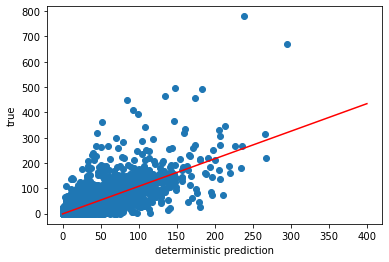

RMSE: 27.291401907446794, MAE: 11.858712234050529, SMAE: 1.3152470178049627


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.596     
Dependent Variable: RH-fix           AIC:                39459.8789
Date:               2022-06-20 13:03 BIC:                39472.5212
No. Observations:   4110             Log-Likelihood:     -19728.   
Df Model:           1                F-statistic:        6060.     
Df Residuals:       4108             Prob (F-statistic): 0.00      
R-squared:          0.596            Scale:              864.87    
--------------------------------------------------------------------
                 Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
--------------------------------------------------------------------
const           -1.1183    0.5411  -2.0666  0.0388  -2.1791  -0.0574
median_pred      1.0891    0.0140  77.8486  0.0000   1.0617   1.1166
-------------------------------------------------------------------
Omnibus:            3625.030      Durbin-Watson:         1.961     
Prob(Omnibus):      0.000         Jarque-Bera (JB):      246741.614
Skew:               3.887         Prob(JB):              0.000     
Kurtosis:           40.154        Condition No.:         46        
===================================================================

"""

In [162]:
ols_median = stm.OLS(combined_data_model["RH-fix"], stm.add_constant(combined_data_model["median_pred"])).fit()
plt.scatter(combined_data["median_pred"], combined_data["RH-fix"])
plt.xlabel("deterministic prediction")
plt.ylabel("true")
x = np.linspace(0, 400)
plt.plot(x, ols_median.predict(stm.add_constant(x)), color="red")
plt.show()

ols_median_predict = ols_median.predict(stm.add_constant(combined_data_test["median_pred"]))
get_error_statistics(combined_data_test["RH-fix"], ols_median_predict)

ols_median.summary2()

### OLS on mode

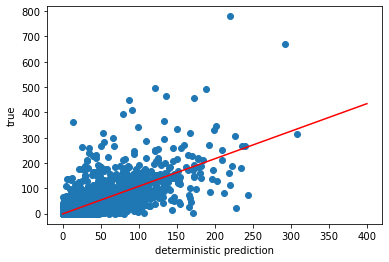

RMSE: 27.291401907446794, MAE: 11.858712234050529, SMAE: 1.3152470178049627


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.573     
Dependent Variable: RH-fix           AIC:                39689.5742
Date:               2022-06-20 13:03 BIC:                39702.2165
No. Observations:   4110             Log-Likelihood:     -19843.   
Df Model:           1                F-statistic:        5508.     
Df Residuals:       4108             Prob (F-statistic): 0.00      
R-squared:          0.573            Scale:              914.58    
---------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
---------------------------------------------------------------------
const         0.7883     0.5462    1.4433   0.1490   -0.2825   1.8592
mode_pred     1.0692     0.0144   74.2139   0.0000    1.0410   1.0975
-------------------------------------------------------------------
Omnibus:            3673.637      Durbin-Watson:         1.973     
Prob(Omnibus):      0.000         Jarque-Bera (JB):      271380.175
Skew:               3.943         Prob(JB):              0.000     
Kurtosis:           42.020        Condition No.:         44        
===================================================================

"""

In [163]:
ols_mode = stm.OLS(combined_data_model["RH-fix"], stm.add_constant(combined_data_model["mode_pred"])).fit()
plt.scatter(combined_data["mode_pred"], combined_data["RH-fix"])
plt.xlabel("deterministic prediction")
plt.ylabel("true")
x = np.linspace(0, 400)
plt.plot(x, ols_median.predict(stm.add_constant(x)), color="red")
plt.show()

ols_mode_predict = ols_mode.predict(stm.add_constant(combined_data_test["mode_pred"]))
get_error_statistics(combined_data_test["RH-fix"], ols_median_predict)

ols_mode.summary2()

### OLS on all descriptive statistics

In [164]:
ols_stats = stm.OLS(combined_data_model["RH-fix"], stm.add_constant(combined_data_model[["det_run", "mean_pred", "median_pred", "min_pred", "max_pred"]])).fit(cov_type="HC0")
# plt.scatter(combined_data["median_pred"], combined_data["RH-fix"])
# plt.xlabel("deterministic prediction")
# plt.ylabel("true")
# x = np.linspace(0, 400)
# plt.plot(x, ols_median.predict(stm.add_constant(x)), color="red")
# plt.show()

ols_desc_predict = ols_stats.predict(stm.add_constant(combined_data_test[["det_run", "mean_pred", "median_pred", "min_pred", "max_pred"]]))
get_error_statistics(combined_data_test["RH-fix"], ols_desc_predict)

ols_stats.summary2()

RMSE: 27.331109233412427, MAE: 11.76715154623634, SMAE: 1.3093811127234958


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.598     
Dependent Variable: RH-fix           AIC:                39442.9068
Date:               2022-06-20 13:04 BIC:                39480.8339
No. Observations:   4110             Log-Likelihood:     -19715.   
Df Model:           5                F-statistic:        169.8     
Df Residuals:       4104             Prob (F-statistic): 1.32e-164 
R-squared:          0.598            Scale:              860.47    
--------------------------------------------------------------------
                  Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
--------------------------------------------------------------------
const            -0.9333    0.6108  -1.5280  0.1265  -2.1304  0.2638
det_run           0.0149    0.0957   0.1558  0.8762  -0.1727  0.2025
mean_pred        -0.4334    0.8200  -0.5285  0.5971  -2.0406  1.1738
median_pred       1.1936    0.7682   1.5538  0.1202  -0.3120  2.6992
min_pred          0.3991    0.2505   1.5930  0.1112  -0.0919  0.8901
max_pred          0.0708    0.0636   1.1131  0.2657  -0.0538  0.1954
-------------------------------------------------------------------
Omnibus:            3713.259      Durbin-Watson:         1.963     
Prob(Omnibus):      0.000         Jarque-Bera (JB):      258522.250
Skew:               4.039         Prob(JB):              0.000     
Kurtosis:           41.005        Condition No.:         136       
===================================================================

"""

### Basic model
This is just a basic model, with only significant parameters.

In [126]:
ols_basic = stm.OLS(combined_data["RH-fix"], stm.add_constant(combined_data[["median_pred"]])).fit(cov_type="HC0")
ols_basic.summary2()

# Deze heeft gewon dezelfde error statistics als het median model

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.606     
Dependent Variable: RH-fix           AIC:                53222.0999
Date:               2022-06-20 12:02 BIC:                53235.3484
No. Observations:   5565             Log-Likelihood:     -26609.   
Df Model:           1                F-statistic:        865.0     
Df Residuals:       5563             Prob (F-statistic): 7.70e-177 
R-squared:          0.606            Scale:              833.37    
--------------------------------------------------------------------
                 Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
--------------------------------------------------------------------
const           -1.4685    0.5544  -2.6489  0.0081  -2.5551  -0.3819
median_pred      1.0966    0.0373  29.4102  0.0000   1.0235   1.1696
-------------------------------------------------------------------
Omnibus:            5499.023      Durbin-Watson:         1.917     
Prob(Omnibus):      0.000         Jarque-Bera (JB):      651551.263
Skew:               4.515         Prob(JB):              0.000     
Kurtosis:           55.234        Condition No.:         46        
===================================================================

"""

### Tests on basic model
#### Chow break test
The different stations might have different results.

In [127]:
median_chow = combined_data[["median_pred"] * 3]
median_chow.columns = [f"median_pred_{i}" for i in ["is-240", "is-260", "is-310"]]

for i, s_n in enumerate(["is-240", "is-260", "is-310"]):
    index = median_chow.index[combined_data[s_n] != 1]
    median_chow.loc[index, median_chow.columns[i]] = 0

m_chow = combined_data.join(median_chow)
stm.OLS(m_chow["RH-fix"], m_chow[["median_pred", "is-240", "is-260", "is-310", "median_pred_is-240", "median_pred_is-260", "median_pred_is-310"]]).fit(cov_type="HC0").f_test("is-240 = is-260 = is-310 = median_pred_is-240 = median_pred_is-260 = median_pred_is-310 = 0")

/Users/micha/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[559.40869551]]), p=0.0, df_denom=5.56e+03, df_num=6>

Thus the statistics parameters differ per station.

In [165]:
m_chow_model = m_chow[m_chow.index.get_level_values(0) < datetime.datetime(2020, 1, 1)]
m_chow_test = m_chow[m_chow.index.get_level_values(0) >= datetime.datetime(2020, 1, 1)]

ols_break_fixed = stm.OLS(m_chow_model["RH-fix"], stm.add_constant(m_chow_model[["median_pred", "is-240", "is-260", "median_pred_is-240", "median_pred_is-260"]])).fit(cov_type="HC0")

ols_break_fixed_predict = ols_break_fixed.predict(stm.add_constant(m_chow_test[["median_pred", "is-240", "is-260", "median_pred_is-240", "median_pred_is-260"]]))
get_error_statistics(m_chow_test["RH-fix"], ols_break_fixed_predict)

ols_break_fixed.summary2()

RMSE: 27.433688193624135, MAE: 11.773602389231115, SMAE: 1.3143423614348153


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.598     
Dependent Variable: RH-fix           AIC:                39445.8189
Date:               2022-06-20 13:07 BIC:                39483.7459
No. Observations:   4110             Log-Likelihood:     -19717.   
Df Model:           5                F-statistic:        212.4     
Df Residuals:       4104             Prob (F-statistic): 5.29e-202 
R-squared:          0.598            Scale:              861.08    
-------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------
const                -0.5700   0.6785 -0.8400 0.4009 -1.8998 0.7599
median_pred           1.0094   0.0476 21.2137 0.0000  0.9162 1.1027
is-240               -1.0885   1.5453 -0.7044 0.4812 -4.1172 1.9401
is-260               -0.5842   0.9893 -0.5905 0.5549 -2.5233 1.3549
median_pred_is-240    0.0964   0.1025  0.9409 0.3468 -0.1044 0.2973
median_pred_is-260    0.1430   0.0740  1.9323 0.0533 -0.0020 0.2881
-------------------------------------------------------------------
Omnibus:            3608.652      Durbin-Watson:         1.965     
Prob(Omnibus):      0.000         Jarque-Bera (JB):      242989.125
Skew:               3.861         Prob(JB):              0.000     
Kurtosis:           39.868        Condition No.:         170       
===================================================================

"""

#### Ramsey RESET for non-linearity
Thus we accept linearity.

In [166]:
linear_reset(ols_break_fixed, use_f=True, cov_type="HC0")

/Users/micha/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[0.81239246]]), p=0.44386642422746203, df_denom=4.1e+03, df_num=2>

#### Breusch-Godfrey for hetroskedacity

In [168]:
basic_bp = het_breuschpagan(ols_break_fixed.resid, m_chow_model[["median_pred"]])
f"P-value: {basic_bp[3]}, thus we {'accept' if basic_bp[3] >= 0.05 else 'reject'} homoskedacity"

'P-value: 5.982583161049855e-129, thus we reject homoskedacity'

### Non-hetroskedastic basic model
#### Using log
We cannot use log to create a homoskedastic model, since we have many 0 values

In [178]:
ols_basic_log = stm.OLS(np.log(m_chow_model["RH-fix"] + 1), stm.add_constant(np.log(m_chow_model[["median_pred", "is-240", "is-260", "median_pred_is-240", "median_pred_is-260"]] + 1))).fit(cov_type="HC0")

ols_basic_log_predict = np.exp(ols_basic_log.predict(stm.add_constant(np.log(m_chow_test[["median_pred", "is-240", "is-260", "median_pred_is-240", "median_pred_is-260"]] + 1)))) - 1
get_error_statistics(m_chow_test["RH-fix"], ols_basic_log_predict)

ols_basic_log.summary2()

RMSE: 35.241892665528205, MAE: 13.306188837536705, SMAE: 1.3491726614559951


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.693     
Dependent Variable: RH-fix           AIC:                11544.9634
Date:               2022-06-21 10:48 BIC:                11582.8905
No. Observations:   4110             Log-Likelihood:     -5766.5   
Df Model:           5                F-statistic:        2642.     
Df Residuals:       4104             Prob (F-statistic): 0.00      
R-squared:          0.693            Scale:              0.97011   
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
const              -0.2549   0.0244 -10.4265 0.0000 -0.3028 -0.2070
median_pred         0.8941   0.0144  62.1604 0.0000  0.8659  0.9223
is-240             -0.0501   0.0528  -0.9493 0.3425 -0.1535  0.0533
is-260             -0.1046   0.0516  -2.0273 0.0426 -0.2058 -0.0035
median_pred_is-240  0.0254   0.0199   1.2734 0.2029 -0.0137  0.0645
median_pred_is-260  0.0531   0.0198   2.6854 0.0072  0.0143  0.0918
-------------------------------------------------------------------
Omnibus:              212.037       Durbin-Watson:          1.764  
Prob(Omnibus):        0.000         Jarque-Bera (JB):       266.284
Skew:                 -0.519        Prob(JB):               0.000  
Kurtosis:             3.691         Condition No.:          21     
===================================================================

"""

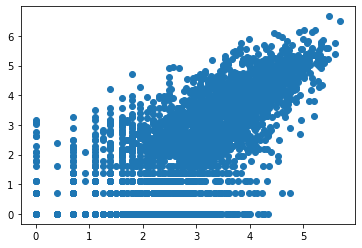

In [170]:
plt.scatter(np.log(combined_data["median_pred"] + 1), np.log(combined_data["RH-fix"] + 1))
plt.show()

In [171]:
basic_ols_log_bp = het_breuschpagan(ols_basic_log.resid, combined_data[["median_pred"]])
f"P-value: {basic_ols_log_bp[3]}, thus we {'accept' if basic_ols_log_bp[3] >= 0.05 else 'reject'} homoskedacity"

'P-value: 6.254575281149824e-134, thus we reject homoskedacity'

#### FWLS

In [172]:
print("White SE")
display(ols_break_fixed.HC0_se)
print("Homoskedicity-only SE")
stm.OLS(m_chow["RH-fix"], m_chow[["median_pred", "is-240", "is-260", "median_pred_is-240", "median_pred_is-260"]]).fit().bse

White SE


const                 0.678524
median_pred           0.047584
is-240                1.545267
is-260                0.989348
median_pred_is-240    0.102493
median_pred_is-260    0.074011
dtype: float64

Homoskedicity-only SE


median_pred           0.017299
is-240                0.794489
is-260                0.797115
median_pred_is-240    0.026504
median_pred_is-260    0.027323
dtype: float64

In [180]:
e_x_df = combined_data[["median_pred", "min_pred", "max_pred", "RH-fix"]].join(ols_basic.resid.rename("e"))
e_var_given_x1 = e_x_df.groupby(np.log(e_x_df["median_pred"] + 1).round(1)).agg({"e": "var", "median_pred": "count"})
e_var_given_x1 = e_var_given_x1[e_var_given_x1["median_pred"] > 10] # drop values with less then 10 datapoints
e_var_given_x1.rename({"median_pred": "number_of_values"}, axis=1, inplace=True)
e_var_given_x1.reset_index(inplace=True)
e_var_given_x1.loc[:, "median_pred"] = np.exp(e_var_given_x1["median_pred"]) - 1
error_ols = stm.OLS(np.log(e_var_given_x1["e"]), stm.add_constant(e_var_given_x1["median_pred"])).fit() # multiplicative

# plt.scatter(e_var_given_x1["median_pred"], np.log(e_var_given_x1["e"] + 10000))
# plt.show()

display(error_ols.summary2())

# np.exp(error_ols.predict(stm.add_constant(combined_data["median_pred"])))

fwls_basic = stm.WLS(
    m_chow_model["RH-fix"], 
    stm.add_constant(m_chow_model[["median_pred", "is-240", "is-260", "median_pred_is-240", "median_pred_is-260"]]), 
    weights= 1/(np.exp(error_ols.predict(stm.add_constant(m_chow_model["median_pred"]))) -1)
).fit()

fwls_basic_predict = fwls_basic.predict(stm.add_constant(m_chow_test[["median_pred", "is-240", "is-260", "median_pred_is-240", "median_pred_is-260"]]))
get_error_statistics(m_chow_test["RH-fix"], fwls_basic_predict)

fwls_basic.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.592   
Dependent Variable: e                AIC:                174.4835
Date:               2022-06-21 10:58 BIC:                178.1407
No. Observations:   46               Log-Likelihood:     -85.242 
Df Model:           1                F-statistic:        66.17   
Df Residuals:       44               Prob (F-statistic): 2.59e-10
R-squared:          0.601            Scale:              2.4911  
------------------------------------------------------------------
                 Coef.   Std.Err.     t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
const            4.2371    0.3040  13.9369  0.0000  3.6244  4.8498
median_pred      0.0360    0.0044   8.1344  0.0000  0.0271  0.0449
-----------------------------------------------------------------
Omnibus:               9.485        Durbin-Watson:          0.513
Prob(Omnibus):         0.009        Jarque-Bera (JB):       9.014
Skew:                  -1.053       Prob(JB):               0.011
Kurtosis:              3.519        Condition No.:          90   
=================================================================

"""

RMSE: 27.428738419405573, MAE: 11.5481251752733, SMAE: 1.3082684419758326


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Weighted least squares
===================================================================
Model:              WLS              Adj. R-squared:     0.445     
Dependent Variable: RH-fix           AIC:                34581.0725
Date:               2022-06-21 10:58 BIC:                34618.9995
No. Observations:   4110             Log-Likelihood:     -17285.   
Df Model:           5                F-statistic:        660.4     
Df Residuals:       4104             Prob (F-statistic): 0.00      
R-squared:          0.446            Scale:              1.8386    
-------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
-------------------------------------------------------------------
const                -0.4401   0.4161 -1.0577 0.2902 -1.2558 0.3757
median_pred           0.9974   0.0313 31.8536 0.0000  0.9360 1.0588
is-240               -0.1058   0.5933 -0.1783 0.8585 -1.2690 1.0574
is-260               -0.5718   0.5937 -0.9631 0.3355 -1.7358 0.5922
median_pred_is-240    0.0333   0.0446  0.7471 0.4551 -0.0541 0.1207
median_pred_is-260    0.1268   0.0448  2.8301 0.0047  0.0390 0.2146
-------------------------------------------------------------------
Omnibus:            3402.930      Durbin-Watson:         1.918     
Prob(Omnibus):      0.000         Jarque-Bera (JB):      120747.682
Skew:               3.755         Prob(JB):              0.000     
Kurtosis:           28.469        Condition No.:         56        
===================================================================

"""

In [136]:
basic_fwls_bp = het_breuschpagan(fwls_basic.resid, combined_data[["median_pred"]])
f"P-value: {basic_fwls_bp[3]}, thus we {'accept' if basic_fwls_bp[3] >= 0.05 else 'reject'} homoskedacity"

'P-value: 1.150394945659042e-131, thus we reject homoskedacity'

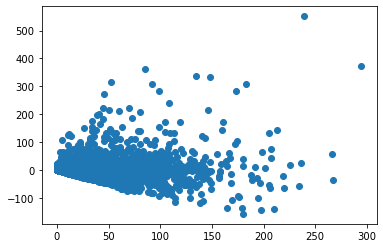

In [137]:
plt.scatter(combined_data["median_pred"], fwls_basic.resid)

#### WLS based on prediction std

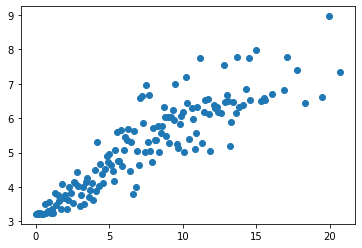

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.788   
Dependent Variable: e                AIC:                270.2708
Date:               2022-06-20 12:02 BIC:                276.2652
No. Observations:   148              Log-Likelihood:     -133.14 
Df Model:           1                F-statistic:        548.2   
Df Residuals:       146              Prob (F-statistic): 2.75e-51
R-squared:          0.790            Scale:              0.35874 
-------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
const        3.4143     0.0921   37.0861   0.0000   3.2323   3.5962
pred_std     0.2364     0.0101   23.4133   0.0000   0.2164   0.2563
-----------------------------------------------------------------
Omnibus:              10.686       Durbin-Watson:          1.949 
Prob(Omnibus):        0.005        Jarque-Bera (JB):       11.165
Skew:                 0.567        Prob(JB):               0.004 
Kurtosis:             3.725        Condition No.:          17    
=================================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Weighted least squares
===================================================================
Model:              WLS              Adj. R-squared:     0.281     
Dependent Variable: RH-fix           AIC:                44959.8470
Date:               2022-06-20 12:02 BIC:                44999.5925
No. Observations:   5565             Log-Likelihood:     -22474.   
Df Model:           5                F-statistic:        436.4     
Df Residuals:       5559             Prob (F-statistic): 0.00      
R-squared:          0.282            Scale:              0.010796  
-------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
-------------------------------------------------------------------
const                 0.0108   0.0128  0.8438 0.3988 -0.0143 0.0359
median_pred           0.5739   0.0124 46.2529 0.0000  0.5495 0.5982
is-240                0.0031   0.0247  0.1243 0.9011 -0.0453 0.0515
is-260               -0.0004   0.0247 -0.0181 0.9855 -0.0490 0.0481
is-310                0.0082   0.0242  0.3390 0.7346 -0.0392 0.0556
median_pred_is-240    0.2180   0.0228  9.5648 0.0000  0.1733 0.2627
median_pred_is-260    0.2521   0.0240 10.4879 0.0000  0.2050 0.2993
median_pred_is-310    0.1037   0.0244  4.2487 0.0000  0.0559 0.1516
-------------------------------------------------------------------
Omnibus:           6963.661   Durbin-Watson:      1.930            
Prob(Omnibus):     0.000      Jarque-Bera (JB):   1504076.158      
Skew:              6.689      Prob(JB):           0.000            
Kurtosis:          82.420     Condition No.:      14946324440832462
===================================================================
* The condition number is large (1e+16). This might indicate
strong multicollinearity or other numerical problems.
"""

In [138]:
e_std_df = combined_data[["median_pred", "min_pred", "max_pred", "RH-fix", "pred_std"]].join(ols_basic.resid.rename("e"))
e_var_given_std = e_std_df.groupby(e_std_df["pred_std"].round(1)).agg({"e": "var", "pred_std": "mean", "median_pred": "count"})
e_var_given_std = e_var_given_std[e_var_given_std["median_pred"] > 10]

plt.scatter(e_var_given_std["pred_std"], np.log(e_var_given_std["e"] + 25)) # If we add + 25, we get a staight line
plt.show()

error_std_ols = stm.OLS(np.log(e_var_given_std["e"] + 25), stm.add_constant(e_var_given_std["pred_std"])).fit()
display(error_std_ols.summary2())

std_wls_basic = stm.WLS(m_chow["RH-fix"], stm.add_constant(m_chow[["median_pred", "is-240", "is-260", "is-310", "median_pred_is-240", "median_pred_is-260", "median_pred_is-310"]]), weights= 1/((np.exp(error_std_ols.predict(stm.add_constant(combined_data["pred_std"]))) - 25)**2)).fit()
display(std_wls_basic.summary2())

In [139]:
basic_std_wls_bp = het_breuschpagan(std_wls_basic.resid, combined_data[["median_pred"]])
f"P-value: {basic_std_wls_bp[3]}, thus we {'accept' if basic_std_wls_bp[3] >= 0.05 else 'reject'} homoskedacity"

'P-value: 1.6213869700545717e-131, thus we reject homoskedacity'

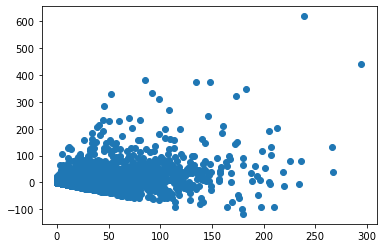

In [140]:
plt.scatter(combined_data["median_pred"], std_wls_basic.resid)

Ik weet oprecht niet waarom, maar ik kan deze hetroskedasity niet wegkrijgen. Dit zou wel mogelijk moeten zijn.

## Basic model with current statistics
### Add additional data

In [141]:
import datetime

current_statistics_hourly = true_weather[["DD", "FH", "T", "P", "N", "U"]] # ik wil ook nog Q toevoegen, alleen die is 's nachts altijd 0, dus dan kan het gemiddelde ofzo
current_statistics = current_statistics_hourly.groupby([pd.Grouper(freq="D", level=0), current_statistics_hourly.index.get_level_values(1)]).last()
current_statistics.index = pd.MultiIndex.from_arrays([current_statistics.index.get_level_values(0) - datetime.timedelta(1), current_statistics.index.get_level_values(1)])
current_statistics: pd.DataFrame
current_statistics[current_statistics.index.get_level_values(0) >= datetime.datetime(2010, 1, 1)]
current_statistics.index.rename({"STN": "loc_nr"}, inplace=True)

current_statistics.loc[:, "D-N"] = ((current_statistics["DD"] > 337.5) | (current_statistics["DD"] <= 22.5)).astype(int)
current_statistics.loc[:, "D-NE"] = ((current_statistics["DD"] > 22.5) & (current_statistics["DD"] <= 67.5)).astype(int)
current_statistics.loc[:, "D-E"] = ((current_statistics["DD"] > 67.5) & (current_statistics["DD"] <= 112.5)).astype(int)
current_statistics.loc[:, "D-SE"] = ((current_statistics["DD"] > 112.5) & (current_statistics["DD"] <= 157.5)).astype(int)
current_statistics.loc[:, "D-S"] = ((current_statistics["DD"] > 157.5) & (current_statistics["DD"] <= 202.5)).astype(int)
current_statistics.loc[:, "D-SW"] = ((current_statistics["DD"] > 202.5) & (current_statistics["DD"] <= 247.5)).astype(int)
current_statistics.loc[:, "D-W"] = ((current_statistics["DD"] > 247.5) & (current_statistics["DD"] <= 292.5)).astype(int)
current_statistics.loc[:, "D-NW"] = ((current_statistics["DD"] > 292.5) & (current_statistics["DD"] <= 337.5)).astype(int)

combined_additional_data = m_chow.join(current_statistics)
combined_additional_data.dropna(inplace=True) # FIXME het lieft los ik gewoon dit probleem op
combined_additional_data

,,det_run,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,N,U,D-N,D-NE,D-E,D-SE,D-S,D-SW,D-W,D-NW
date,loc_nr,,,,,,,,,,,,,,,,,,,,,
2016-04-01,260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,70.0,0,0,0,1,0,0,0,0
2016-04-02,260,1.0,1.0,5.0,2.0,3.0,3.0,1.0,1.0,2.0,1.0,...,8.0,96.0,0,0,0,0,1,0,0,0
2016-04-03,260,34.0,20.0,8.0,22.0,19.0,26.0,19.0,28.0,12.0,25.0,...,8.0,94.0,0,0,1,0,0,0,0,0
2016-04-04,260,17.0,44.0,54.0,29.0,29.0,44.0,54.0,9.0,61.0,22.0,...,7.0,85.0,0,0,0,0,0,1,0,0
2016-04-05,260,30.0,18.0,8.0,24.0,58.0,36.0,41.0,30.0,43.0,25.0,...,0.0,75.0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,56.0,0,1,0,0,0,0,0,0
2021-04-27,240,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,...,8.0,74.0,1,0,0,0,0,0,0,0
2021-04-28,240,41.0,27.0,10.0,38.0,29.0,5.0,31.0,14.0,32.0,20.0,...,8.0,90.0,0,0,0,0,0,0,0,1


### Basic model with additional statistics

In [142]:
median_direction = combined_additional_data[["median_pred"] * 8]
median_direction.columns = [f"median_pred_{i}" for i in ["D-N", "D-NE", "D-E", "D-SE", "D-S", "D-SW", "D-W", "D-NW"]]
for i, c_n in enumerate(["D-N", "D-NE", "D-E", "D-SE", "D-S", "D-SW", "D-W", "D-NW"]):
    index = median_direction.index[combined_additional_data[c_n] != 1]
    median_direction.loc[index, median_direction.columns[i]] = 0

combined_with_binary = combined_additional_data.join(median_direction)
combined_with_binary.to_hdf("combined_with_binary.hdf5", "binary")
combined_with_binary


/Users/micha/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,,det_run,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,D-W,D-NW,median_pred_D-N,median_pred_D-NE,median_pred_D-E,median_pred_D-SE,median_pred_D-S,median_pred_D-SW,median_pred_D-W,median_pred_D-NW
date,loc_nr,,,,,,,,,,,,,,,,,,,,,
2016-04-01,260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-02,260,1.0,1.0,5.0,2.0,3.0,3.0,1.0,1.0,2.0,1.0,...,0,0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2016-04-03,260,34.0,20.0,8.0,22.0,19.0,26.0,19.0,28.0,12.0,25.0,...,0,0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0
2016-04-04,260,17.0,44.0,54.0,29.0,29.0,44.0,54.0,9.0,61.0,22.0,...,0,0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0
2016-04-05,260,30.0,18.0,8.0,24.0,58.0,36.0,41.0,30.0,43.0,25.0,...,0,0,0.0,0.0,0.0,0.0,0.0,31.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-04-27,240,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-04-28,240,41.0,27.0,10.0,38.0,29.0,5.0,31.0,14.0,32.0,20.0,...,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0


In [174]:
combined_with_binary_model = combined_with_binary[combined_with_binary.index.get_level_values(0) < datetime.datetime(2020, 1, 1)]
combined_with_binary_test = combined_with_binary[combined_with_binary.index.get_level_values(0) >= datetime.datetime(2020, 1, 1)]

max_model = stm.OLS(combined_with_binary_model["RH-fix"], stm.add_constant(combined_with_binary_model[["median_pred", "is-240", "is-260", "median_pred_is-240", "median_pred_is-260", "min_pred", "max_pred", "mean_pred", "mode_pred", "T", "P", "N", "U", "FH", "D-N", "D-NE", "D-E", "D-SE", "D-S", "D-SW", "D-W", "median_pred_D-N", "median_pred_D-NE", "median_pred_D-E", "median_pred_D-SE", "median_pred_D-S", "median_pred_D-SW", "median_pred_D-W"]])).fit(cov_type="HC0")

max_model_predict = max_model.predict(stm.add_constant(combined_with_binary_test[["median_pred", "is-240", "is-260", "median_pred_is-240", "median_pred_is-260", "min_pred", "max_pred", "mean_pred", "mode_pred", "T", "P", "N", "U", "FH", "D-N", "D-NE", "D-E", "D-SE", "D-S", "D-SW", "D-W", "median_pred_D-N", "median_pred_D-NE", "median_pred_D-E", "median_pred_D-SE", "median_pred_D-S", "median_pred_D-SW", "median_pred_D-W"]]))
get_error_statistics(combined_with_binary_test["RH-fix"], max_model_predict)

max_model.summary2()

RMSE: 27.300280753330245, MAE: 12.006139826096687, SMAE: 1.3157447913468592


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:                OLS               Adj. R-squared:      0.606     
Dependent Variable:   RH-fix            AIC:                 39373.4297
Date:                 2022-06-20 13:16  BIC:                 39556.7369
No. Observations:     4109              Log-Likelihood:      -19658.   
Df Model:             28                F-statistic:         76.33     
Df Residuals:         4080              Prob (F-statistic):  0.00      
R-squared:            0.609             Scale:               843.31    
-----------------------------------------------------------------------
                     Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-----------------------------------------------------------------------
const              -131.7323  52.7342 -2.4980 0.0125 -235.0895 -28.3751
median_pred           1.3806   0.7801  1.7699 0.0767   -0.1483   2.9095
is-240               -1.0165   1.4648 -0.6940 0.4877   -3.8874   1.8544
is-260               -1.0545   1.1322 -0.9313 0.3517   -3.2736   1.1646
median_pred_is-240    0.0581   0.0901  0.6449 0.5190   -0.1185   0.2347
median_pred_is-260    0.1189   0.0731  1.6271 0.1037   -0.0243   0.2622
min_pred              0.3455   0.2384  1.4490 0.1473   -0.1218   0.8129
max_pred              0.0731   0.0616  1.1868 0.2353   -0.0476   0.1938
mean_pred            -0.4325   0.7930 -0.5453 0.5855   -1.9868   1.1218
mode_pred            -0.0882   0.1834 -0.4807 0.6307   -0.4476   0.2713
T                     0.0048   0.0078  0.6103 0.5416   -0.0106   0.0202
P                     0.0131   0.0050  2.6000 0.0093    0.0032   0.0230
N                    -0.1720   0.1649 -1.0430 0.2969   -0.4951   0.1512
U                    -0.0282   0.0435 -0.6481 0.5170   -0.1134   0.0571
FH                   -0.0326   0.0220 -1.4863 0.1372   -0.0756   0.0104
D-N                   0.9778   1.7453  0.5603 0.5753   -2.4429   4.3986
D-NE                  2.0236   1.6934  1.1950 0.2321   -1.2954   5.3426
D-E                   3.5586   1.8527  1.9208 0.0548   -0.0726   7.1897
D-SE                  0.5198   2.3463  0.2215 0.8247   -4.0789   5.1185
D-S                   1.9004   2.3558  0.8067 0.4198   -2.7168   6.5177
D-SW                  5.1698   1.8949  2.7283 0.0064    1.4559   8.8837
D-W                   1.8657   2.1161  0.8817 0.3780   -2.2818   6.0131
median_pred_D-N      -0.2632   0.1132 -2.3250 0.0201   -0.4850  -0.0413
median_pred_D-NE     -0.2522   0.1491 -1.6908 0.0909   -0.5445   0.0401
median_pred_D-E      -0.2770   0.1661 -1.6677 0.0954   -0.6025   0.0485
median_pred_D-SE      0.1059   0.1730  0.6123 0.5403   -0.2331   0.4450
median_pred_D-S      -0.0656   0.1316 -0.4984 0.6182   -0.3235   0.1923
median_pred_D-SW     -0.2062   0.1153 -1.7889 0.0736   -0.4322   0.0197
median_pred_D-W      -0.0664   0.1314 -0.5055 0.6132   -0.3239   0.1910
-----------------------------------------------------------------------
Omnibus:              3644.848       Durbin-Watson:          1.974     
Prob(Omnibus):        0.000          Jarque-Bera (JB):       240002.890
Skew:                 3.937          Prob(JB):               0.000     
Kurtosis:             39.603         Condition No.:          1231908   
=======================================================================
* The condition number is large (1e+06). This might indicate
strong multicollinearity or other numerical problems.
"""

#### Only use significant

In [175]:
additional_model = stm.OLS(combined_with_binary_model["RH-fix"], stm.add_constant((combined_with_binary_model[["median_pred", "P", "FH", "D-N"]]))).fit(cov_type="HC0")
# display(additional_model.pvalues.idxmax(), additional_model.pvalues.max())

additional_model_predict = additional_model.predict(stm.add_constant((combined_with_binary_test[["median_pred", "P", "FH", "D-N"]])))
get_error_statistics(combined_with_binary_test["RH-fix"], additional_model_predict)

display(additional_model.summary2())

RMSE: 27.175664776030132, MAE: 12.038056318695096, SMAE: 1.3247162753809396


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.598     
Dependent Variable: RH-fix           AIC:                39435.2799
Date:               2022-06-20 13:19 BIC:                39466.8846
No. Observations:   4109             Log-Likelihood:     -19713.   
Df Model:           4                F-statistic:        215.4     
Df Residuals:       4104             Prob (F-statistic): 4.88e-168 
R-squared:          0.598            Scale:              861.09    
-------------------------------------------------------------------
                 Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-------------------------------------------------------------------
const          -115.6486  45.7027 -2.5305 0.0114 -205.2242 -26.0729
median_pred       1.1000   0.0414 26.5390 0.0000    1.0188   1.1812
P                 0.0115   0.0045  2.5729 0.0101    0.0027   0.0202
FH               -0.0475   0.0198 -2.4039 0.0162   -0.0863  -0.0088
D-N              -4.5618   1.3417 -3.4001 0.0007   -7.1914  -1.9322
-------------------------------------------------------------------
Omnibus:            3597.676      Durbin-Watson:         1.966     
Prob(Omnibus):      0.000         Jarque-Bera (JB):      241181.956
Skew:               3.845         Prob(JB):              0.000     
Kurtosis:           39.737        Condition No.:         1133277   
===================================================================
* The condition number is large (1e+06). This might indicate
strong multicollinearity or other numerical problems.
"""

In [145]:
combined_with_binary[["median_pred", "is-240", "is-260", "is-310", "median_pred_is-240", "median_pred_is-260", "median_pred_is-310", "P", "FH", "D-N", "D-NE", "D-E", "D-SE", "D-S", "D-SW", "D-W", "D-NW"]].corr().replace(1, np.nan).idxmax().to_frame().join(combined_with_binary[["median_pred", "is-240", "is-260", "is-310", "median_pred_is-240", "median_pred_is-260", "median_pred_is-310", "P", "FH", "D-N", "D-NE", "D-E", "D-SE", "D-S", "D-SW", "D-W", "D-NW"]].corr().replace(1, np.nan).max().rename("max"))

,0,max
median_pred,median_pred_is-240,0.528805
is-240,median_pred_is-240,0.461864
is-260,median_pred_is-260,0.465986
is-310,median_pred_is-310,0.453840
median_pred_is-240,median_pred,0.528805
median_pred_is-260,median_pred,0.492631
median_pred_is-310,median_pred,0.515546
P,D-NE,0.132896
FH,is-310,0.389533
D-N,P,0.104820


#### Ramsey RESET

In [146]:
linear_reset(max_model, use_f=True, cov_type="HC0")

/Users/micha/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[4.37694205]]), p=0.01260724959926315, df_denom=5.53e+03, df_num=2>

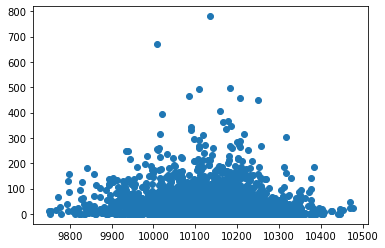

In [147]:
plt.scatter(combined_with_binary[combined_with_binary["R"] == 1]["P"], combined_with_binary[combined_with_binary["R"] == 1]["RH-fix"])

## Predictive rain prediction model
First predict rain probability, then predict how much it would likely rain.

In [148]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [149]:
num_pos =  (combined_with_binary[[f"E{i+1}" for i in range(50)]] > 0).sum(axis=1).rename("num_pos")
num_high_pos = (combined_with_binary[[f"E{i+1}" for i in range(50)]] > 20).sum(axis=1).rename("num_high_pos")
num_very_pos = (combined_with_binary[[f"E{i+1}" for i in range(50)]] > 100).sum(axis=1).rename("num_very_pos")
combined_with_perc = combined_with_binary.join(num_pos).join(num_high_pos).join(num_very_pos)
combined_with_perc

,,det_run,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,median_pred_D-NE,median_pred_D-E,median_pred_D-SE,median_pred_D-S,median_pred_D-SW,median_pred_D-W,median_pred_D-NW,num_pos,num_high_pos,num_very_pos
date,loc_nr,,,,,,,,,,,,,,,,,,,,,
2016-04-01,260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0,0
2016-04-02,260,1.0,1.0,5.0,2.0,3.0,3.0,1.0,1.0,2.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,42,0,0
2016-04-03,260,34.0,20.0,8.0,22.0,19.0,26.0,19.0,28.0,12.0,25.0,...,0.0,22.0,0.0,0.0,0.0,0.0,0.0,50,29,0
2016-04-04,260,17.0,44.0,54.0,29.0,29.0,44.0,54.0,9.0,61.0,22.0,...,0.0,0.0,0.0,0.0,29.0,0.0,0.0,50,39,0
2016-04-05,260,30.0,18.0,8.0,24.0,58.0,36.0,41.0,30.0,43.0,25.0,...,0.0,0.0,0.0,0.0,31.5,0.0,0.0,50,34,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2021-04-27,240,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,0,0
2021-04-28,240,41.0,27.0,10.0,38.0,29.0,5.0,31.0,14.0,32.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,21.0,50,25,0


In [150]:
combined_with_perc.columns

Index(['det_run', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10',
       'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20',
       'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29', 'E30',
       'E31', 'E32', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E40',
       'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48', 'E49', 'E50',
       'E51', 'mean_pred', 'median_pred', 'min_pred', 'max_pred', 'pred_std',
       'pred_skew', 'pred_kurt', 'mode_pred', 'mode2_pred', 'mean_det_pred',
       'RH-fix', 'R', 'is-260', 'is-310', 'is-240', 'median_pred_is-240',
       'median_pred_is-260', 'median_pred_is-310', 'DD', 'FH', 'T', 'P', 'N',
       'U', 'D-N', 'D-NE', 'D-E', 'D-SE', 'D-S', 'D-SW', 'D-W', 'D-NW',
       'median_pred_D-N', 'median_pred_D-NE', 'median_pred_D-E',
       'median_pred_D-SE', 'median_pred_D-S', 'median_pred_D-SW',
       'median_pred_D-W', 'median_pred_D-NW', 'num_pos', 'num_high_pos',
       'num_very_pos'],
      

In [151]:
def perc_corr_pred(model, data, true, perc = 0.5):
    pred_value = np.zeros(len(data))
    is_corr = np.zeros(len(data))
    true_value = np.array(true)
    
    pred_value = model.predict(data)[1] > perc

    return np.equal(pred_value, true_value).mean()

In [152]:
logit_model = OrderedModel(combined_with_binary["R"], combined_with_perc[["num_pos"]], distr="logit").fit(method="bfgs")
display(perc_corr_pred(logit_model, combined_with_perc[["num_pos"]], combined_with_binary["R"]))
display(logit_model.summary())
display(logit_model.prsquared)

Optimization terminated successfully.
         Current function value: 0.355100
         Iterations: 14
         Function evaluations: 17
         Gradient evaluations: 17


0.8594536304816679

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      R   Log-Likelihood:                -1975.8
Model:                   OrderedModel   AIC:                             3956.
Method:            Maximum Likelihood   BIC:                             3969.
Date:                Mon, 20 Jun 2022                                         
Time:                        12:02:13                                         
No. Observations:                5564                                         
Df Residuals:                    5562                                         
Df Model:                           2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
num_pos        0.1155      0.003     37.113      0.000       0.109       0.122
0.0/1.0        3.8857      0.138     28.189      0.000       3.615       4.156
==============================================================================
"""

0.47267781327798664

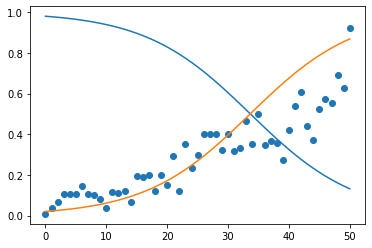

In [153]:
_data = combined_with_perc.groupby("num_pos").mean()["R"]
plt.scatter(_data.index, _data.values)
x = np.arange(0, 51)
plt.plot(x, logit_model.predict(x))
plt.show()

In [154]:
gompit_model = OrderedModel(combined_with_binary["R"], combined_with_perc[["num_pos"]], distr=sts.gumbel_r).fit(method="bfgs")
display(perc_corr_pred(gompit_model, combined_with_perc[["num_pos"]], combined_with_binary["R"]))
display(gompit_model.summary())
display(gompit_model.prsquared)

Optimization terminated successfully.
         Current function value: 0.347179
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16


0.8632278936017254

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      R   Log-Likelihood:                -1931.7
Model:                   OrderedModel   AIC:                             3867.
Method:            Maximum Likelihood   BIC:                             3881.
Date:                Mon, 20 Jun 2022                                         
Time:                        12:02:14                                         
No. Observations:                5564                                         
Df Residuals:                    5562                                         
Df Model:                           2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
num_pos        0.0881      0.003     34.611      0.000       0.083       0.093
0.0/1.0        3.6260      0.121     29.923      0.000       3.389       3.864
==============================================================================
"""

0.4844410988106389

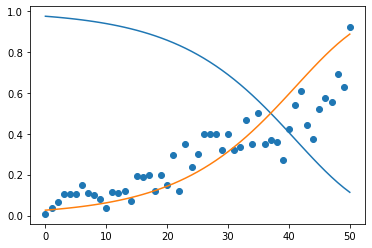

In [155]:
_data = combined_with_perc.groupby("num_pos").mean()["R"]
plt.scatter(_data.index, _data.values)
x = np.arange(0, 51)
plt.plot(x, gompit_model.predict(x))
plt.show()

In [156]:
expon_model = OrderedModel(combined_with_binary["R"], combined_with_perc[["num_pos"]], distr=sts.expon).fit(method="bfgs")
display(perc_corr_pred(expon_model, combined_with_perc[["num_pos"]], combined_with_binary["R"]))
display(expon_model.summary())
display(expon_model.prsquared)

Optimization terminated successfully.
         Current function value: 0.337952
         Iterations: 14
         Function evaluations: 17
         Gradient evaluations: 17


0.8684399712437095

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      R   Log-Likelihood:                -1880.4
Model:                   OrderedModel   AIC:                             3765.
Method:            Maximum Likelihood   BIC:                             3778.
Date:                Mon, 20 Jun 2022                                         
Time:                        12:02:14                                         
No. Observations:                5564                                         
Df Residuals:                    5562                                         
Df Model:                           2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
num_pos        0.0645      0.002     30.829      0.000       0.060       0.069
0.0/1.0        3.3215      0.104     32.004      0.000       3.118       3.525
==============================================================================
"""

0.4981438763007129

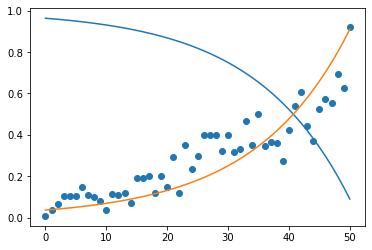

In [157]:
_data = combined_with_perc.groupby("num_pos").mean()["R"]
plt.scatter(_data.index, _data.values)
x = np.arange(0, 51)
plt.plot(x, expon_model.predict(x))
plt.show()

In [158]:
wald_model = OrderedModel(combined_with_binary["R"], combined_with_perc[["num_pos"]], distr=sts.wald).fit(method="bfgs")
display(perc_corr_pred(wald_model, combined_with_perc[["num_pos"]], combined_with_binary["R"]))
display(wald_model.summary())
display(wald_model.prsquared)

Optimization terminated successfully.
         Current function value: 0.338369
         Iterations: 15
         Function evaluations: 21
         Gradient evaluations: 21


0.8662832494608196

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      R   Log-Likelihood:                -1882.7
Model:                   OrderedModel   AIC:                             3769.
Method:            Maximum Likelihood   BIC:                             3783.
Date:                Mon, 20 Jun 2022                                         
Time:                        12:02:14                                         
No. Observations:                5564                                         
Df Residuals:                    5562                                         
Df Model:                           2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
num_pos        0.0567      0.002     26.233      0.000       0.052       0.061
0.0/1.0        3.0634      0.107     28.587      0.000       2.853       3.273
==============================================================================
"""

0.4975240120996641

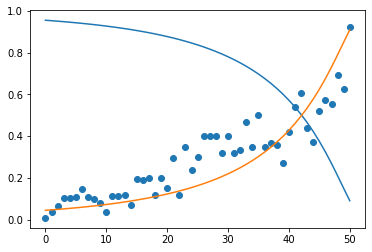

In [159]:
_data = combined_with_perc.groupby("num_pos").mean()["R"]
plt.scatter(_data.index, _data.values)
x = np.arange(0, 51)
plt.plot(x, wald_model.predict(x))
plt.show()

In [160]:
wald_model = OrderedModel(combined_with_binary["R"], combined_with_perc[["num_pos", "num_high_pos"]], distr=sts.wald).fit(method="bfgs")
# display(perc_corr_pred(wald_model, combined_with_perc[["num_pos"]], combined_with_binary["R"]))
display(wald_model.summary())
display(wald_model.prsquared)

Optimization terminated successfully.
         Current function value: 0.303206
         Iterations: 13
         Function evaluations: 20
         Gradient evaluations: 20


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      R   Log-Likelihood:                -1687.0
Model:                   OrderedModel   AIC:                             3380.
Method:            Maximum Likelihood   BIC:                             3400.
Date:                Mon, 20 Jun 2022                                         
Time:                        12:02:15                                         
No. Observations:                5564                                         
Df Residuals:                    5561                                         
Df Model:                           3                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
num_pos          0.0492      0.002     23.927      0.000       0.045       0.053
num_high_pos     0.0053      0.000     18.493      0.000       0.005       0.006
0.0/1.0          2.8095      0.101     27.940      0.000       2.612       3.007
================================================================================
"""

0.5497415042904881